In [7]:
%matplotlib inline
import mglearn
import matplotlib.pyplot as plt
import numpy as np

## Kernelized Support Vector Machines

These are an extension of the linear SVMs discussed previously that allow for more complex models that are not smply defined by hyperplanes in the input space.

The discussion will be restricted to classification, similar . In `scikit-learn` the support vector classification is implemented in `SVC`, while support vector regression is implemented in `SVM`.

The math behind these methods is involved and beyond the scope of this book.  See chapter 12 of [this book](https://web.stanford.edu/~hastie/ElemStatLearn//) for more insight to that.


##### Linear models and nonlinear features

As we saw when discussing the linear SVMs, linear models can be quite limiting in low-dimension spaces.  A way to make a linear model more flexible is by adding more features (e.g. by adding interactions or polynomials of input features).

Text(0, 0.5, 'Feature 1')

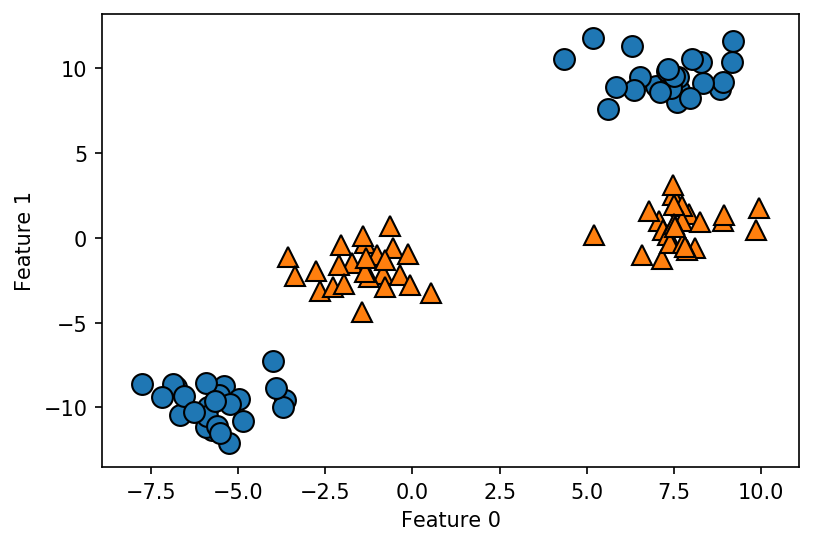

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2
plt.figure(dpi=150)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

For this dataset, a line would obviously not do a good job to classify these datapoints.  This is shown below:

c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

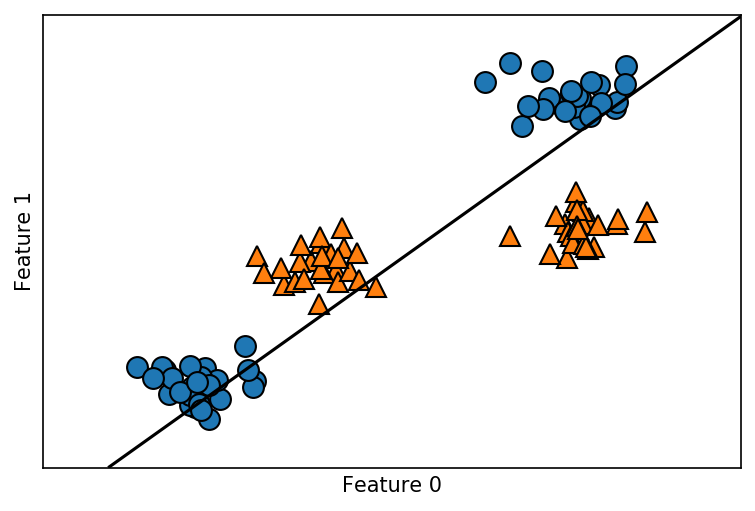

In [5]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)
plt.figure(dpi=150)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

We'll exapnd our features now by adding `feature1 ** 2` as a new one and we'll represent each data point as a 3D point `(feature0, feature1, feature1**2)`.

_NOTE:_ The choice of feature isn't particularly important in this particular case.  It was just for illustration purposes.

Now we will have a 3-dimensional plot.

Text(0.5, 0, 'feature1 ** 2')

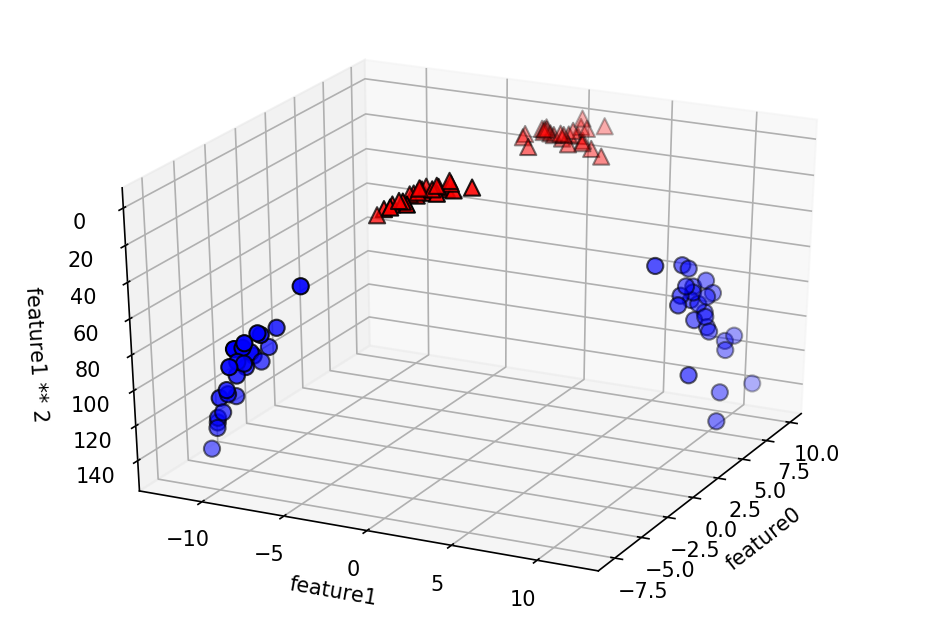

In [9]:
# add the squared second feature
X_new = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure(dpi=150)
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

c:\ipynot~1\intro-ml\venv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1 ** 2')

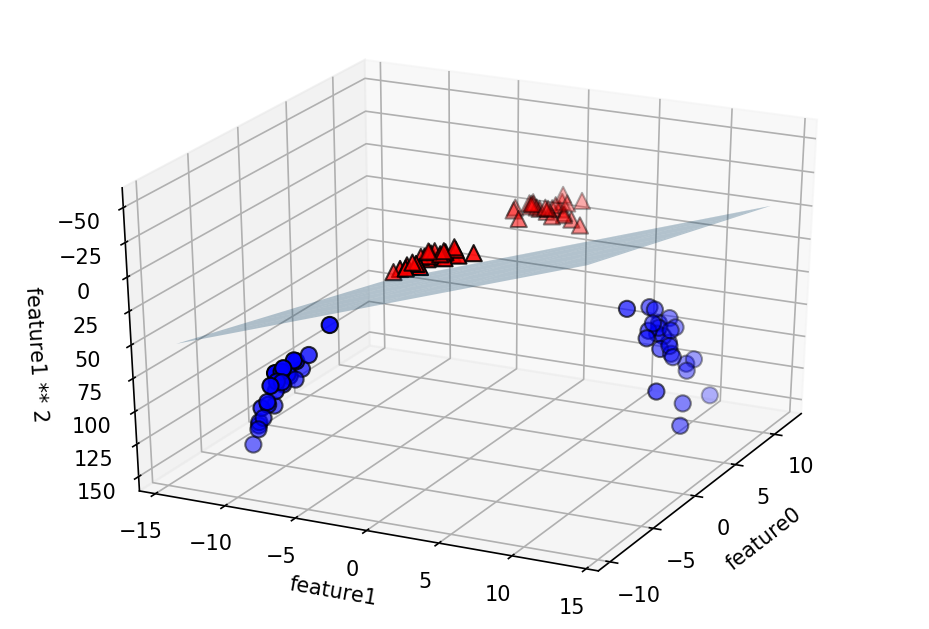

In [11]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_
# show linear decision boundary
figure = plt.figure(dpi=150)
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

So we can see that the linear SVM on the expanded set is able to separate the two classes.  As a function of the original features our linear SVM is not linear anymore, but more elliptical.

Text(0, 0.5, 'Feature 1')

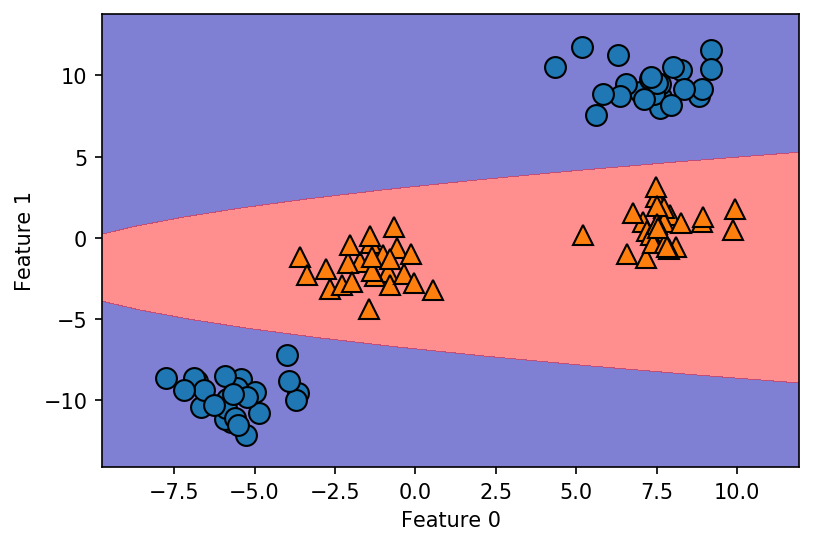

In [13]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.figure(dpi=150)
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##### The kernel trick

Here we learned that adding nonlinear features the representation of our data males linear models more powerful.  We won't always know which feature to add though and adding many features (e.g. adding all the interations in a high dimensional space) can be computationally expensive.  There is a mathematical trick that will help get around this problem though, called the __kernel trick__.  This works by computing the distance (or scalar product) of each of the data points for the expanded feature representation without computing the actual expansion.

The two ways to map data to higher dimensions that are commonly used are the polynomial kernel
* computes all possible polynomials up to a certain degree
and the radial bias function (RBF) kernel
* harder to explain
* corresponds to an infinite-dimension space
* considers polynomials of all degrees with higher degrees having lesser importance (because of Taylor expansion of exponential).

In practive the math isn't important and the RBF kernel's decision making can be summarized easily (which will be done later).

##### Understanding SVMs

While the model is training the SVM learns the importance of each training point in representing the decision boundary.  Usually only a subset of points is important for defining the boundary, the points along the border of the boundary.  These points are __support vectors__, hence the name support vector machines.

Predictions for new points are made by measuring the distance to each support vector.  The prediction is made based on the distances and the importances learned during training.  The importances are stored in the `dual_coef_` attribute of the model object.

The Gaussian kernel measures distances:

$$k_{rbf}(x_1, x_2) = exp(- \gamma \lVert x_1 - x_2 \rVert) $$

Here $x_1$ and $x_2$ are the data points and $\lVert x_1 - x_2 \rVert$ is the Euclidean distance. $\gamma$ is a parameter controlling the width of the kernel.

Text(0, 0.5, 'Feature 1')

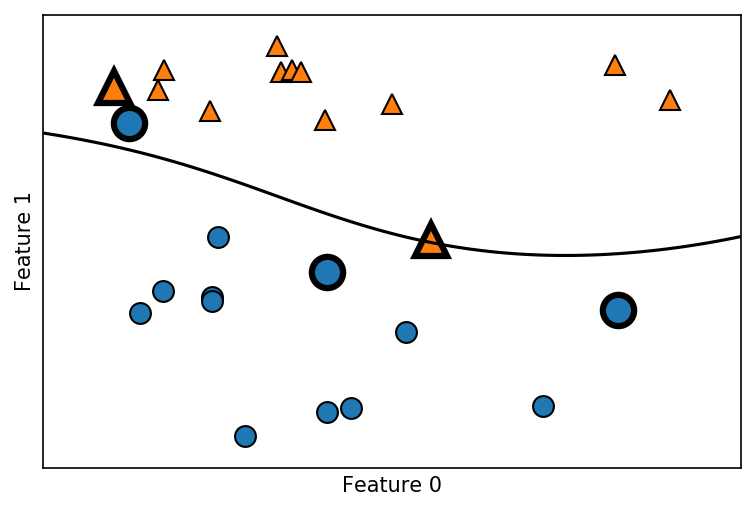

In [15]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
plt.figure(dpi=150)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Here is the result of training on a two dimensional dataset.  The decision boundary is the line and the support vectors are the points with the bolded outlines.  We can see that a very smooth and non-linear boundary is returned.  Two parameters were adjusted for this, `C` and `gamma`.

##### Tuning SVM parameters

The `gamma` parameter (which is the $\gamma$ in the equation above) corresponds to the inverse of the width of the Gaussian kernel.  Intuitively this parameter determines how far the influence of a training example has (so a low `gamma` is high reach and the opposite for a high `gamma`).  So a bigger radius the more influence for each training example and vice versa.  For the parameter `C`, it is a regularization parameter like in the linear models discussed previously.  It limits the importance of each point (their `dual_coef_`).

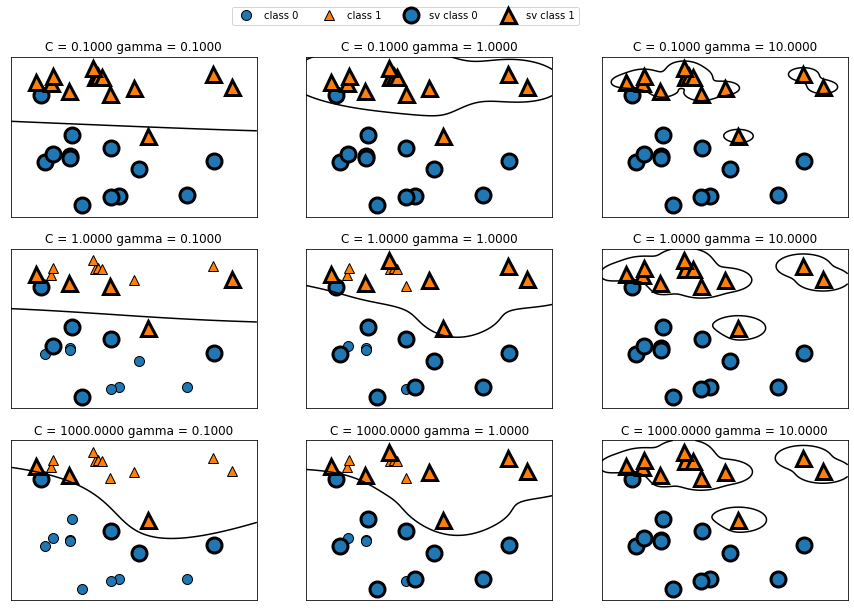

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))

From left to right `gamma` increases and from top to bottom `C` increases. Lower gammas give smoother decision boundaries and less complex models.  Lower `C` parameters are more restricted like in the linear models.